# 🌀 Hurricane Ian WRF Analysis (No WRF-Python)
This notebook performs hurricane center detection and analysis **without using `wrf-python`**.

Steps:
1. Load WRF data.
2. Find the hurricane center from pressure, wind, and computed vorticity.
3. Create a vortex-centered coordinate system.
4. Compute radial and tangential wind components.
5. Plot results.

In [2]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from pyproj import Proj, Transformer
from pathlib import Path

## 1️⃣ Load WRF Dataset

In [4]:
data_path = Path('../data/wrfout_d03_2022-09-26_Ian2022_UNCPL.nc')
ds = nc.Dataset(data_path)
lat = ds.variables['XLAT'][0, :, :]
lon = ds.variables['XLONG'][0, :, :]
print(f"Loaded WRF file with shape: {lat.shape}")

print(len(ds.dimensions['Time']))
t = 51

Loaded WRF file with shape: (717, 669)
73


## 2️⃣ Find Hurricane Center (Surface Pressure Minimum)

In [5]:
for test_t in range(0, 73, 5):  # Test every 5th timestep
    try:
        psfc_test = ds.variables['PSFC'][test_t, :, :]
        print(f"Timestep {test_t} loaded successfully.")
    except RuntimeError as e:
        print(f"Timestep {test_t} failed: {e}")
        break

Timestep 0 loaded successfully.
Timestep 5 failed: NetCDF: HDF error


In [192]:
t = 51

psfc = ds.variables['PSFC'][t, :, :] / 100  # Pa → hPa
imin = np.unravel_index(np.argmin(psfc), psfc.shape)
center_lat_psfc, center_lon_psfc = float(lat[imin]), float(lon[imin])
print(f"Center (min PSFC): {center_lat_psfc:.2f}°, {center_lon_psfc:.2f}°")

Center (min PSFC): 24.40°, -83.88°


## 3️⃣ Compute Approximate 850-hPa Vorticity Without `wrf-python`

In [6]:
# Approximate relative vorticity from 10-m winds for demonstration
u10 = ds.variables['U10'][t, :, :]
v10 = ds.variables['V10'][t, :, :]
deg2m = 111000  # rough conversion (1 degree ~ 111 km)
dy, dx = np.gradient(lat * deg2m, axis=0), np.gradient(lon * deg2m, axis=1)
dVdx = np.gradient(v10, axis=1) / (dx + 1e-9)
dUdy = np.gradient(u10, axis=0) / (dy + 1e-9)
f = 2 * 7.2921e-5 * np.sin(np.deg2rad(lat))  # Coriolis parameter
vort = dVdx - dUdy + f
imax = np.unravel_index(np.argmax(vort), vort.shape)
center_lat_vort, center_lon_vort = float(lat[imax]), float(lon[imax])
print(f"Center (max vorticity): {center_lat_vort:.2f}°, {center_lon_vort:.2f}°")

Center (max vorticity): 25.86°, -83.73°


## 4️⃣ Find Hurricane Center (10-m Wind Speed Minimum)

In [7]:
wind_speed = np.sqrt(u10**2 + v10**2)
imin_ws = np.unravel_index(np.argmin(wind_speed), wind_speed.shape)
center_lat_ws, center_lon_ws = float(lat[imin_ws]), float(lon[imin_ws])
print(f"Center (min 10-m wind): {center_lat_ws:.2f}°, {center_lon_ws:.2f}°")

Center (min 10-m wind): 26.27°, -81.85°


## 5️⃣ Create Vortex-Centered Azimuthal Equidistant Projection

In [8]:
center_lat, center_lon = center_lat_psfc, center_lon_psfc
aeqd = Proj(proj='aeqd', lat_0=center_lat, lon_0=center_lon, datum='WGS84')
transformer = Transformer.from_proj('epsg:4326', aeqd, always_xy=True)
x, y = transformer.transform(lon, lat)
r = np.sqrt(x**2 + y**2) / 1000  # km
theta = np.degrees(np.arctan2(y, x))
print('Computed storm-centered r and θ grids.')

NameError: name 'center_lat_psfc' is not defined

## 6️⃣ Compute Radial and Tangential Wind Components

In [196]:
radial_wind =  u10 * np.cos(np.radians(theta)) + v10 * np.sin(np.radians(theta))
tangential_wind = -u10 * np.sin(np.radians(theta)) + v10 * np.cos(np.radians(theta))
print('Radial and tangential components computed.')

Radial and tangential components computed.


## 7️⃣ Plot Wind Speed, Vectors, and Center

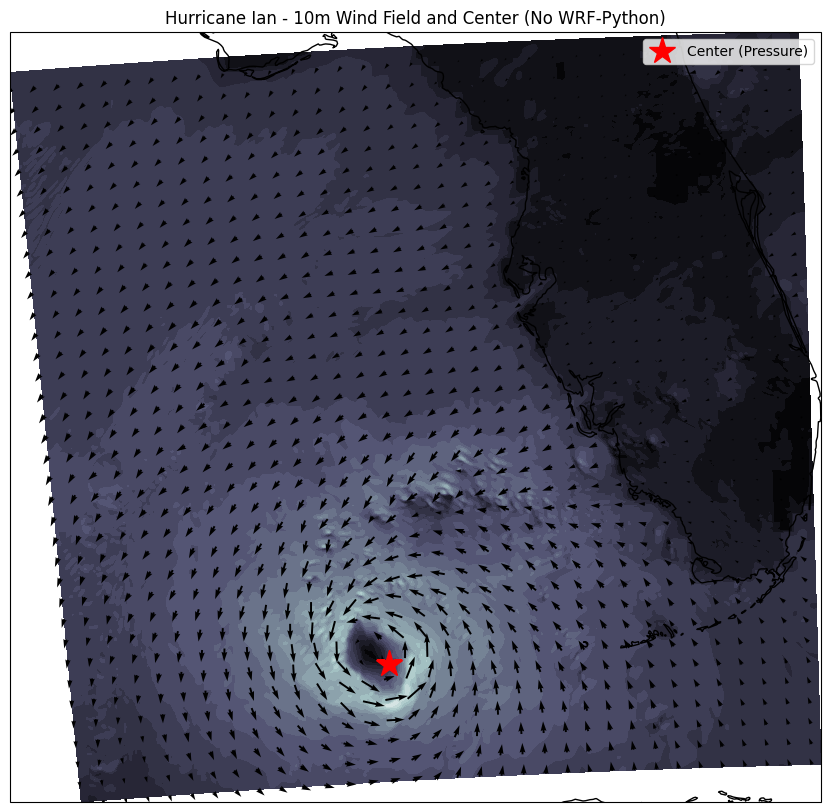

In [197]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone')
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500)
ax.plot(center_lon, center_lat, 'r*', markersize=20, label='Center (Pressure)')
plt.legend()
plt.title('Hurricane Ian - 10m Wind Field and Center (No WRF-Python)')
plt.show()

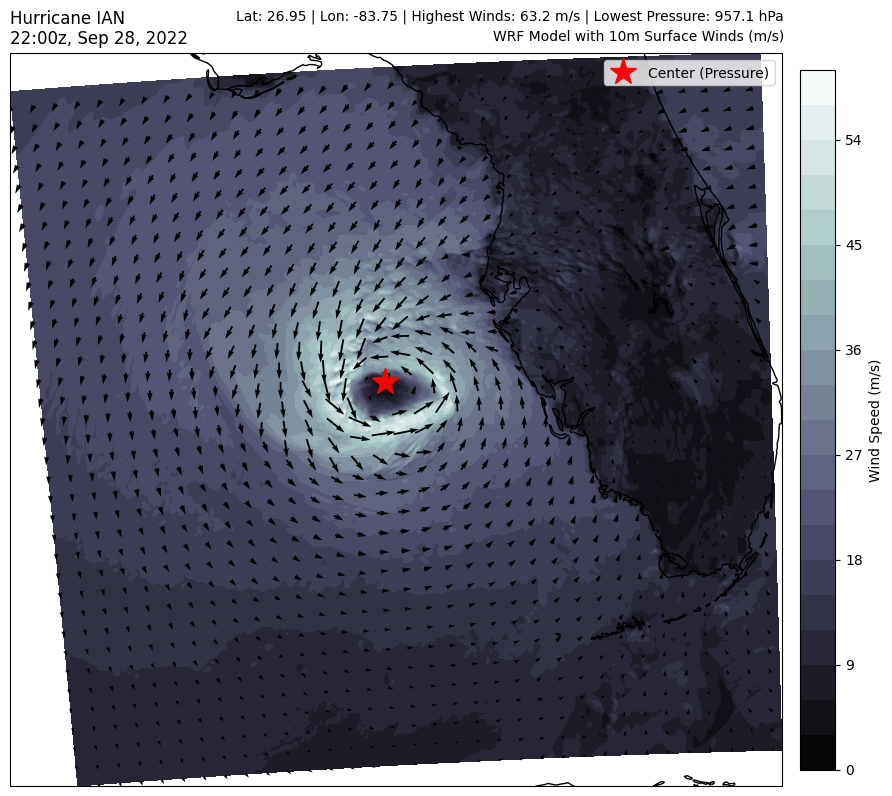

In [147]:
# ... (your existing code up to computing wind_speed, center_lat, center_lon, etc.)

# Extract timestamp for timestep t (assuming 'Times' is a char array like b'2022-09-26_00:00:00')
time_bytes = ds.variables['Times'][t]
time_str = ''.join([byte.decode('utf-8') for byte in time_bytes])
time_dt = datetime.strptime(time_str, '%Y-%m-%d_%H:%M:%S')  # Adjust format if your Times differ
time_formatted = time_dt.strftime('%H:%Mz, %b %d, %Y')  # e.g., '00:00z, Sep 26, 2022'

# Compute max wind and min pressure
max_wind = np.max(wind_speed)
min_pressure = np.min(psfc)

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
im = ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone')  # Store the contour plot in 'im'
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500)
ax.plot(center_lon, center_lat, 'r*', markersize=20, label='Center (Pressure)')
plt.legend()

# Add a smaller colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=20, shrink=0.7)
cbar.set_label('Wind Speed (m/s)', fontsize=10)

# Top title (two lines above the figure)
fig.text(0.125, .91, 'Hurricane IAN', ha='left', va='top', fontsize=12)
fig.text(.77, .91, f'Lat: {center_lat:.2f} | Lon: {center_lon:.2f} | Highest Winds: {max_wind:.1f} m/s | Lowest Pressure: {min_pressure:.1f} hPa',
        ha='right', va='top', fontsize=10)

# Bottom title (two lines below the figure)
fig.text(0.125, .89, time_formatted, ha='left', va='top', fontsize=12)
fig.text(.77, .89, 'WRF Model with 10m Surface Winds (m/s)', ha='right', va='top', fontsize=10)

plt.subplots_adjust(top=1, bottom=0)  # Adjusted right to give more space to colorbar

# Save the plot as a PNG file
fig.savefig('hurricane_ian_plot.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

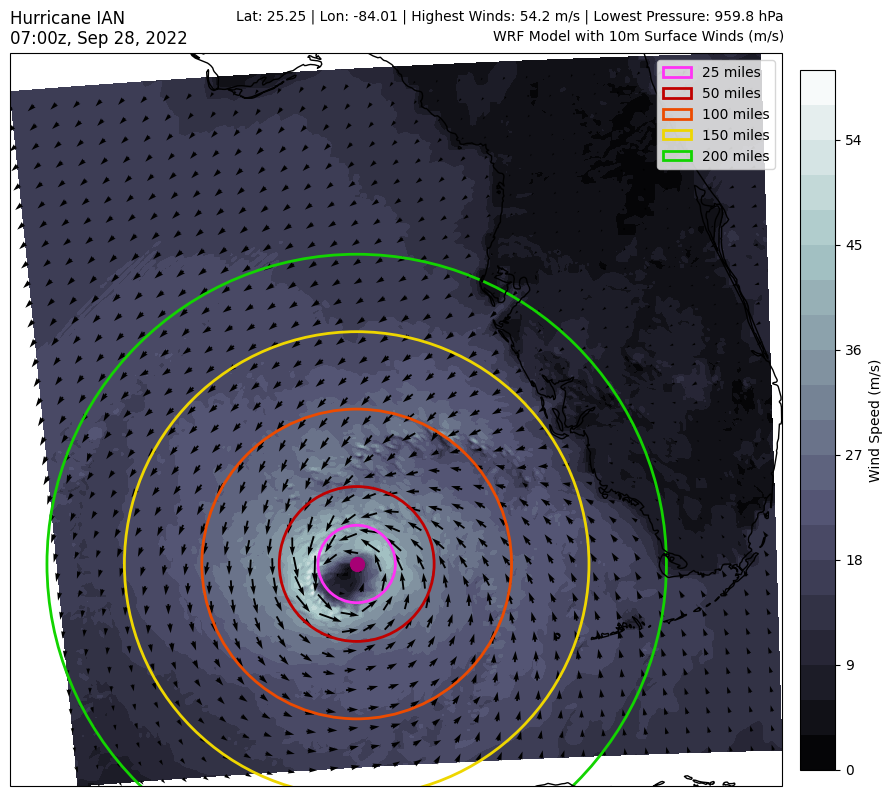

In [169]:
# ... (your existing code up to computing wind_speed, center_lat, center_lon, etc.)

# Extract timestamp for timestep t (assuming 'Times' is a char array like b'2022-09-26_00:00:00')
time_bytes = ds.variables['Times'][t]
time_str = ''.join([byte.decode('utf-8') for byte in time_bytes])
time_dt = datetime.strptime(time_str, '%Y-%m-%d_%H:%M:%S')  # Adjust format if your Times differ
time_formatted = time_dt.strftime('%H:%Mz, %b %d, %Y')  # e.g., '00:00z, Sep 26, 2022'

# Compute max wind and min pressure
max_wind = np.max(wind_speed)
min_pressure = np.min(psfc)

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
im = ax.contourf(lon, lat, wind_speed, levels=np.linspace(0, 60, 21), cmap='bone')  # Store the contour plot in 'im'
ax.quiver(lon[::20,::20], lat[::20,::20], u10[::20,::20], v10[::20,::20], scale=1500)

# Add radial circles with progressively lighter red shades
# Approximate 1 degree ≈ 69 miles; adjust radius in degrees
radius_25_miles = 25/69
radius_50_miles = 50 / 69
radius_100_miles = 100 / 69
radius_150_miles = 150 / 69
radius_200_miles = 200 / 69

rad_25 = plt.Circle((center_lon, center_lat), radius_25_miles, color="#ff32f5", fill=False, linewidth=2, label='25 miles')  # Lightest red
rad_50 = plt.Circle((center_lon, center_lat), radius_50_miles, color="#c00000", fill=False, linewidth=2, label='50 miles')  # Lightest red
rad_100 = plt.Circle((center_lon, center_lat), radius_100_miles, color="#ec4b00", fill=False, linewidth=2, label='100 miles')  # Darker red
rad_150 = plt.Circle((center_lon, center_lat), radius_150_miles, color="#EED600", fill=False, linewidth=2, label='150 miles')  # Even darker
rad_200 = plt.Circle((center_lon, center_lat), radius_200_miles, color="#12D400", fill=False, linewidth=2, label='200 miles')  # Darkest red

ax.add_patch(rad_25)
ax.add_patch(rad_50)
ax.add_patch(rad_100)
ax.add_patch(rad_150)
ax.add_patch(rad_200)

# Add center dot with darkest red and include in legend
center_dot, = ax.plot(center_lon, center_lat, 'o', color="#A70075", markersize=10)  # Darkest red

# Create legend including the center dot
plt.legend(handles=[rad_25, rad_50, rad_100, rad_150, rad_200])

# Add a smaller colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=20, shrink=0.7)
cbar.set_label('Wind Speed (m/s)', fontsize=10)

# Top title (two lines above the figure)
fig.text(0.125, .91, 'Hurricane IAN', ha='left', va='top', fontsize=12)
fig.text(.77, .91, f'Lat: {center_lat:.2f} | Lon: {center_lon:.2f} | Highest Winds: {max_wind:.1f} m/s | Lowest Pressure: {min_pressure:.1f} hPa',
        ha='right', va='top', fontsize=10)

# Bottom title (two lines below the figure)
fig.text(0.125, .89, time_formatted, ha='left', va='top', fontsize=12)
fig.text(.77, .89, 'WRF Model with 10m Surface Winds (m/s)', ha='right', va='top', fontsize=10)

plt.subplots_adjust(top=1, bottom=0)  # Adjusted right to give more space to colorbar

# Save the plot as a PNG file
fig.savefig(f'hurricane_ian_plot_{t}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [132]:
radius_25_miles = 25/69
radius_50_miles = 50 / 69
radius_100_miles = 100 / 69
radius_150_miles = 150 / 69
radius_200_miles = 200 / 69

rad_25 = plt.Circle((center_lon, center_lat), radius_25_miles, color="#ff32f5", fill=False, linewidth=2, label='25 miles')  # Lightest red
rad_50 = plt.Circle((center_lon, center_lat), radius_50_miles, color="#c00000", fill=False, linewidth=2, label='50 miles')  # Lightest red
rad_100 = plt.Circle((center_lon, center_lat), radius_100_miles, color="#ec4b00", fill=False, linewidth=2, label='100 miles')  # Darker red
rad_150 = plt.Circle((center_lon, center_lat), radius_150_miles, color="#EED600", fill=False, linewidth=2, label='150 miles')  # Even darker
rad_200 = plt.Circle((center_lon, center_lat), radius_200_miles, color="#12D400", fill=False, linewidth=2, label='200 miles')  # Darkest red

ax.add_patch(rad_25)
ax.add_patch(rad_50)
ax.add_patch(rad_100)
ax.add_patch(rad_150)
ax.add_patch(rad_200)

# Add center dot with darkest red and include in legend
center_dot, = ax.plot(center_lon, center_lat, 'o', color="#A70075", markersize=20, label='Storm Center')  # Darkest red